In [1]:
import numpy as np
import pandas as pd
from data_processing.csv_reader import CSVReader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from time_series_processing.differencing import Differencer
from data_processing.feature_generation import FeatureGenerator
from environments.stock_env import StockEnvironment
import os
import sys

sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research/terminal")
sys.path.append("C:/Users/YuweiZhu/OneDrive - Alloyed/Documents/Market-Prediction-Research")

from environments.reinforcement_learning_env import ReinforcementLearningEnvironment

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
path = "../raw_data/AAPL.csv"
csvr = CSVReader(path=path)


csvr.get_properties()
df = csvr.get_df()

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099449  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094261  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087343  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089504   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092099   73449600


In [3]:
from charting_tools.visualize_candlesticks import plot_all

In [20]:
fg = FeatureGenerator(df, task="classification")

#fg.apply_bollinger_bands(period=20, target="Close")
#fg.apply_moving_cumulation(periods=[7, 30, 100, 365], target="Profit")
#fg.apply_IG_top_ten_indicators()

#plot_all(fg.df, fg.training_features)
#X_train, X_test, y_train, y_test = fg.create_modelling_data(features=["Close", "Volume"], target="Profit")

In [21]:
X_train, X_test, y_train, y_test = fg.create_modelling_data(features=["Adj Close", "Volume"], target="Profit")

In [22]:
fg.training_features

['20 day moving average', '20 day lower bband', '20 day upper bband']

In [27]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, DotProduct

gpc = GaussianProcessClassifier(**{'kernel': 1**2 + RBF(length_scale=5) + WhiteKernel(noise_level=1), 'n_restarts_optimizer': 10, 'random_state': 123})
gpc.fit(X_train, y_train)
gpc.score(X_test, y_test)

KeyboardInterrupt: 

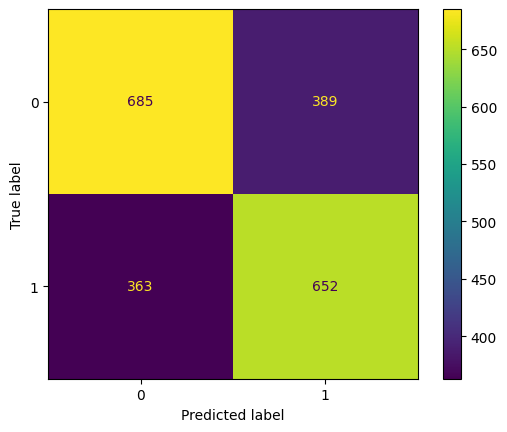

In [7]:
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = gpc.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=gpc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gpc.classes_)
disp.plot()

In [6]:
from sklearn.metrics import r2_score
y_pred = gpc.predict(X_test)
r2_score(y_test, y_pred)

-0.44107291924668135

In [39]:
df["Next Close"] = df["Close"].shift(1)

In [40]:
df["Difference"] = df["Close"] - df["Next Close"]

In [41]:
df["Profit"] = (df["Difference"] > 0).astype(int)

In [42]:
df = df.drop([0])

In [43]:
df = find_recent_trends(df)

In [45]:
df = df.dropna()
df

,Date,Open,High,Low,Close,Adj Close,Volume,Next Close,Difference,Profit,Last 2 days,Last 7 days,Last 30 days,Last 100 days
100,1981-05-07,0.123884,0.124442,0.123884,0.123884,0.095991,9363200,0.122210,0.001674,1,1.0,2.0,11.0,42.0
101,1981-05-08,0.125000,0.125558,0.125000,0.125000,0.096855,7907200,0.123884,0.001116,1,2.0,3.0,12.0,43.0
102,1981-05-11,0.122768,0.122768,0.122210,0.122210,0.094694,11939200,0.125000,-0.002790,0,1.0,2.0,12.0,43.0
103,1981-05-12,0.122210,0.123884,0.122210,0.122210,0.094694,4256000,0.122210,0.000000,0,0.0,2.0,12.0,42.0
104,1981-05-13,0.122210,0.123326,0.121652,0.121652,0.094261,4905600,0.122210,-0.000558,0,0.0,2.0,12.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10804,2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300,175.460007,-2.580002,0,0.0,1.0,15.0,53.0
10805,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100,172.880005,0.119995,1,1.0,1.0,15.0,54.0
10806,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600,173.000000,0.440002,1,2.0,2.0,16.0,54.0
10807,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000,173.440002,-2.339996,0,1.0,2.0,16.0,53.0


In [46]:
X = df[["Open", "High", "Low", "Close", "Volume", "Last 2 days", "Last 7 days", "Last 30 days", "Last 100 days"]]
y = df["Profit"]

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
X_train

array([[-0.47283795, -0.47244167, -0.47293075, ...,  0.38921156,
         0.37390384,  0.22373285],
       [ 0.90294628,  0.89625522,  0.90826908, ...,  1.15135452,
         1.41809624,  1.06521117],
       [-0.47285096, -0.47265206, -0.47283855, ..., -0.3729314 ,
        -0.32222442,  0.22373285],
       ...,
       [-0.48023891, -0.48013208, -0.4802607 , ...,  0.38921156,
        -0.32222442, -1.96411078],
       [-0.47371951, -0.4735623 , -0.4739361 , ...,  0.38921156,
         0.72196797,  0.05543718],
       [-0.48117529, -0.48107129, -0.48117988, ..., -1.89721732,
        -2.41060922, -1.45922379]])

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay

In [55]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)
y_pred = rfr.predict(X_test)

r2_score(y_test, y_pred)

0.518835435076443

In [51]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

0.7894491129785247

In [52]:
mse = lambda x, y : sum((x - y)**2)

avg = np.array([0.5]*len(y_pred))

1 - mse(y_pred, y_test)/mse(avg, y_test)

0.15779645191409897

In [22]:
def threshold(y_pred):

    for i in range(len(y_pred)):
        y_pred[i] = int(y_pred[i] >= 0.5)

    return y_pred

In [27]:
r2_score(y_test, y_pred)

-0.582410301319767

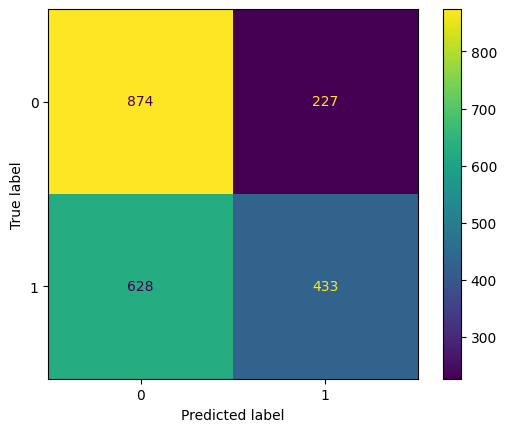

In [28]:
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()